In [42]:
# using Pkg
# Pkg.activate("./")

 Activating new environment at `~/Numerics/RigettiMatching/Project.toml`


In [1]:
using QSimulator 
# using Optim
# using LsqFit
# using NLsolve
# using Roots
# using QuadGK
using PyPlot
using LinearAlgebra
# using Interpolations
# using FFTW
using SpecialFunctions
# import Statistics

# import QuantumInfo: liou, avgfidelity, kraus2liou # open-source package
# import Cliffords: Z
# using Optim
using LinearAlgebra: diagm

┌ Info: Precompiling QSimulator [84ebd660-cff8-11e8-33d2-5334dd07f13c]
└ @ Base loading.jl:1423
┌ Warning: Package QSimulator does not have BSplineKit in its dependencies:
│ - If you have QSimulator checked out for development and have
│   added BSplineKit as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with QSimulator
└ Loading BSplineKit into QSimulator from project dependency, future warnings for QSimulator are suppressed.


In [2]:
# Make sure it's using the local development package
pathof(QSimulator)

"/Users/guenther5/.julia/environments/v1.7/dev/QSimulator/src/QSimulator.jl"

In [3]:
function erfsquare_with_pads(tramp,tf,pad_length,t)
    """
    Error function square pulse
    
    :param tramp:       rise and fall time of the pulse.
    :param tf:          length of the flux pulse (without pads).
    :paramp pad_length: length of pad to be added on each side of the pulse.
    : return errfun:    error function square pulse.
    """
    fwhm = 0.5*tramp
    σ = fwhm/(2.0*sqrt(2.0 *log(2.0)))
    errfun = 0.5*(erf((t -pad_length- tramp)/σ)-erf((t + tramp - pad_length - tf)/σ))
    if t <= pad_length
        return  0
    elseif pad_length <= t <= tf+pad_length 
        return errfun
    elseif tf+pad_length  < t <= tf + 2*pad_length
    return 0
    end
end

erfsquare_with_pads (generic function with 1 method)

In [4]:
#define operators
σ0 = [0.0 1.0 0.0;0.0 0.0 √2.0;0.0 0.0 0.0]    
σz = σ0'*σ0
σ1z = [-1.0 0.0;0.0 1.0]⊗ Matrix(I,2,2)
σ2z =  Matrix(I,2,2)⊗[-1.0 0.0;0.0 1.0]
UiSWAP = [1.0 0.0 0.0 0.0 ;0.0 0.0 1im 0.0; 0.0 1im 0.0 0.0; 0.0 0.0 0.0 1.0]
UCZ = [1.0 0.0 0.0 0.0 ;0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 -1.0]
ln = [1 2 4 5 10 11 13 14 28 29 31 32 37 38 40 41] # indces of initial conditions
Iden = [1.0 0.0 0.0; 0.0 1.0 0.0]⊗[1.0 0.0 0.0; 0.0 1.0 0.0];
UCZ

4×4 Matrix{Float64}:
 1.0  0.0  0.0   0.0
 0.0  1.0  0.0   0.0
 0.0  0.0  1.0   0.0
 0.0  0.0  0.0  -1.0

In [5]:
# Modulation frequencies 
fm_opt_list_CZ = [0.29297, 0.48572]
fm_opt_list_iSWAP = [0.39222]
println("modulation frequency for CZ02 = ", round(fm_opt_list_CZ[1]*1000,digits=2), " MHz")
println("modulation frequency for CZ20 = ", round(fm_opt_list_CZ[2]*1000,digits=2), " MHz")
println("modulation frequency for iSWAP = ", round(fm_opt_list_iSWAP[1]*1000,digits=2), " MHz")

modulation frequency for CZ02 = 292.97 MHz
modulation frequency for CZ20 = 485.72 MHz
modulation frequency for iSWAP = 392.22 MHz


In [6]:
# CZ GATE TIMES 
gatetime_CZ_optimal = [105.15693358991508, 174.86605293763594]

tramp = 8 # ramp time of the flux pulse
pad_length = 8 # padding on each side of the flux pulse 
tf_CZ = gatetime_CZ_optimal .+ 2*tramp
tf_CZ_with_pads = tf_CZ .+ 2*pad_length
println("CZ optimal gate times: ", gatetime_CZ_optimal)

# iSWAP gate times
gatetime_iSWAP_optimal= 99.5250113474233
tf_iSWAP = gatetime_iSWAP_optimal .+ 2*tramp
tf_iSWAP_with_pads = tf_iSWAP .+ 2*pad_length
println("iSWAP optimal gate time: ", gatetime_iSWAP_optimal)

CZ optimal gate times: [105.15693358991508, 174.86605293763594]
iSWAP optimal gate time: 99.5250113474233


In [34]:
# Set up the oscillators 

# fixed-frequency transmon 
f01_f, eta_f = [3.887,0.187]
q1 = DuffingTransmon("q1", 3, DuffingSpec(f01_f, -eta_f) ) 

# tunable transmon
EJ_small, EJ_large, Ec = [3.0729953809760047,17.50233502578641,0.18109155430615317]
q0 = PerturbativeTransmon("q0", 3, TransmonSpec(Ec, EJ_large, EJ_small))  

# drive amplitude for tunable transmon
phim = 0.6  # in units of Phi0. AC sweet spot amplitude


# Coupling
g01 =  0.010

# Lindblad coefficients
T1t = 13000.0 # in ns
Tphit = 7000.0  # in ns
T1f = 38000.0 # in ns
Tphif = 15000.0  # in ns


γ1t = 1/(2π * T1t)
γϕt = 1/(2π * Tphit)
γ1f = 1/(2π * T1f)
γϕf = 1/(2π * Tphif)

println("Decay:   T1_fixed = ", T1f,   " -> 2piT1 = ", 2π * T1f,   " T1_tune  = ", T1t, " -> 2piT1 = ", 2π * T1t)
println("Dephase: T2_fixed = ", Tphif, " -> 2piT2 = ", 2π * Tphif, " T2_tune  = ", Tphit, " -> 2piT2 = ", 2π * Tphit)

Decay:   T1_fixed = 38000.0 -> 2piT1 = 238761.04167282427 T1_tune  = 13000.0 -> 2piT1 = 81681.40899333463
Dephase: T2_fixed = 15000.0 -> 2piT2 = 94247.7796076938 T2_tune  = 7000.0 -> 2piT2 = 43982.2971502571


In [78]:
# CZ20 drive for tunable transmon
# times = collect(0.0:0.01:tf_CZ_with_pads[1])
# driveq0 = t -> phim*erfsquare_with_pads(tramp,tf_CZ[1],pad_length,t).*sin(2π*fm_opt_list_CZ[1]*t)

# iSWAP drive for tunable transmon
times = collect(0.0:0.01:tf_iSWAP_with_pads)
# driveq0 = t -> phim*erfsquare_with_pads(tramp,tf_iSWAP,pad_length,t).*sin(2π*fm_opt_list_iSWAP[1]*t)
driveq0 = t -> phim*sin(2π*fm_opt_list_iSWAP[1]*t)

# driveq0 = t -> phim.*erfsquare_with_pads.(tramp,tf_iSWAP,pad_length,t).*sin.(2π*fm_opt_list_iSWAP[1]*t)
# driveq0 = t -> phim.*erfsquare_with_pads.(tramp,tf_iSWAP,pad_length,t)

# plot(times, driveq0(times))
# println("times=[", times[1],":", times[end], "] ", "drive freq=",fm_opt_list_iSWAP[1])
# println("Tf_iSWAP = ", tf_iSWAP, " tramp = ", tramp, " pad_length = ", pad_length)

# # # ZOOM
# ax = gca()
# ax[:set_xlim]([112,119])
# grid()
fm_opt_list_iSWAP[1]

0.39222

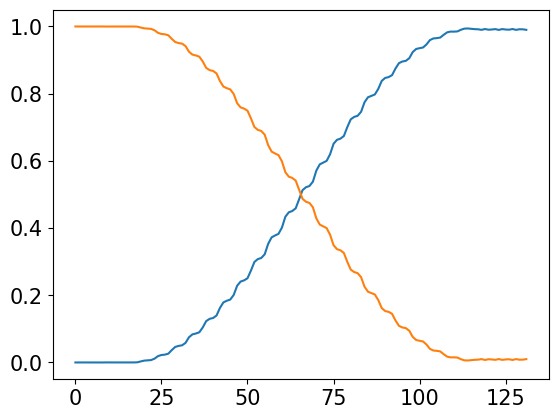

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x2289e7700>

In [88]:
# Construct the system in the LAB frame
cqs = CompositeQSystem([q0, q1])

g = 0.01
freq = 0.3922
phim = 0.6

add_hamiltonian!(cqs, q1)  # fixed transmon
add_hamiltonian!(cqs, g01*X([q0, q1]), [q0,q1]) #coupling
add_hamiltonian!(cqs, parametric_drive(q0, t -> phim*erfsquare_with_pads(tramp,tf_iSWAP,pad_length,t).*sin(2π*freq*t)), q0) # tunable transmon

# Add Lindblad terms
add_lindblad!(cqs, sqrt(γ1t)*σ0, [q0])
add_lindblad!(cqs, sqrt(γϕt)*σz, [q0])
add_lindblad!(cqs, sqrt(γ1f)*σ0, [q1])
add_lindblad!(cqs, sqrt(γϕf)*σz, [q1])

# Initial density matrix rhoin = |10><10|
rho0=zeros(ComplexF64,9,9)
rho0[4,4] = 1.0 + im*0.0  
# print(rhoin)

# Initial state vector in 3x3 system
phi0 = zeros(ComplexF64,9) 
phi0[4] = 1.0 + im*0.0     #|10>

# RUN
times = 0:131
phi_all = unitary_state(cqs, times, phi0);
pop₀₁ = [abs2(ψ[2]) for ψ in phi_all]
pop₁₀ = [abs2(ψ[4]) for ψ in phi_all];
plot(times, pop₀₁)
plot(times, pop₁₀)

In [87]:
tf_iSWAP

115.5250113474233

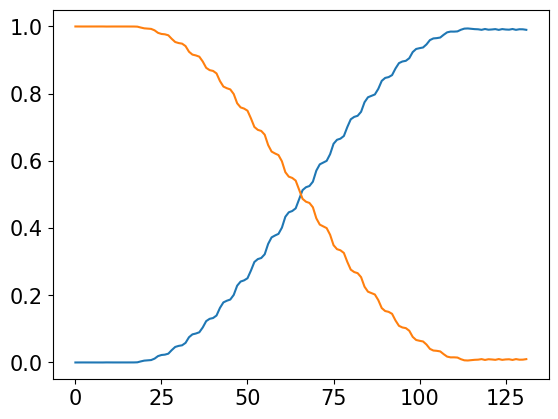

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x228985430>

In [86]:
# Construct the system in the ROTATING frame

cqs = CompositeQSystem([q0, q1])

g = 0.01
freq = 0.3922
phim = 0.6


w1 = spec(q1).frequency
w0 = hamiltonian(q0, 0.0)[2,2]
eta01 = w1 - w0

# add transmons
add_hamiltonian!(cqs, q1)
add_hamiltonian!(cqs, parametric_drive(q0, t -> phim*erfsquare_with_pads(tramp,tf_iSWAP,pad_length,t).*sin(2π*freq*t)), q0)

# substract rotating frame Hamiltonian shifts
add_hamiltonian!(cqs, -w0*number(q0), q0)
add_hamiltonian!(cqs, -w1*number(q1), q1)

# Add time dependent coupling
add_hamiltonian!(cqs, t -> g01*.5*X_Y([q0, q1], [0.0,eta01*t]), [q0,q1])


# Add Lindblad terms
add_lindblad!(cqs, sqrt(γ1t)*σ0, [q0])
add_lindblad!(cqs, sqrt(γϕt)*σz, [q0])
add_lindblad!(cqs, sqrt(γ1f)*σ0, [q1])
add_lindblad!(cqs, sqrt(γϕf)*σz, [q1])

# Initial density matrix rhoin = |10><10|
rho0=zeros(ComplexF64,9,9)
rho0[4,4] = 1.0 + im*0.0  
# print(rhoin)

# Initial state vector in 3x3 system
phi0 = zeros(ComplexF64,9) 
phi0[4] = 1.0 + im*0.0     #|10>

# RUN
times = 0:131
phi_all = unitary_state(cqs, times, phi0);
pop₀₁ = [abs2(ψ[2]) for ψ in phi_all]
pop₁₀ = [abs2(ψ[4]) for ψ in phi_all];
plot(times, pop₀₁)
plot(times, pop₁₀)

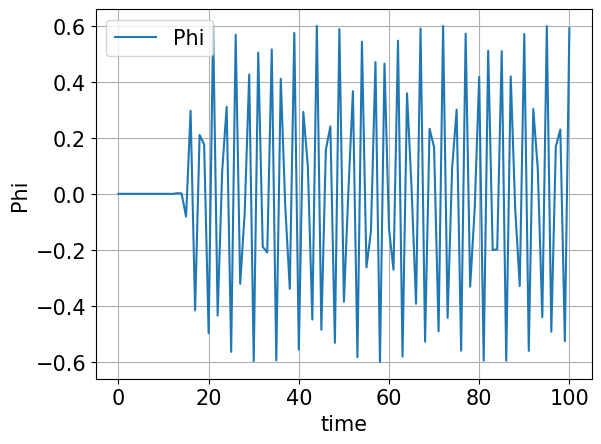

PyObject Text(30.0, 0.5, 'Phi')

In [61]:
# Plot the drive
mydrive = driveq0.(times)

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 15

plot(times, mydrive, label="Phi")
legend()
grid()
xlabel("time")
ylabel("Phi")


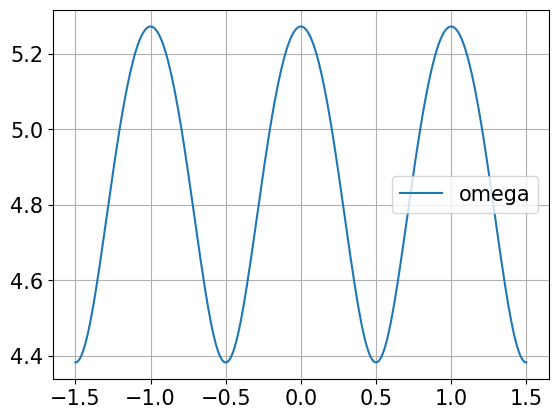

In [40]:
# plot and fit w(x)
# omega = perturbative_transmon_freq.(Ec, EJ_small, EJ_large, driveq0.(times))

x = collect(-1.5:0.01:1.5)
omega = perturbative_transmon_freq.(Ec, EJ_small, EJ_large, x)
plot(x, omega, label="omega")


# # Use a Bspine to fit omega
# using BSplineKit
# print(omega)
# order = 2
# spline_omega = interpolate(x, omega, BSplineOrder(order))

# fit = spline_omega.(x)
# fit = 0.444*sin.(2*pi*(x.+0.25)).+4.826
# plot(x, fit, label="fit")
legend()
grid()

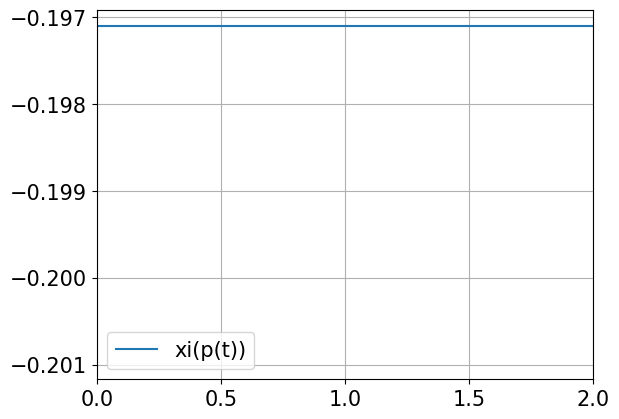

(0.0, 2.0)

In [14]:
# plot w(drive(t))
mydrive = driveq0.(times)
omega_drive = perturbative_transmon_freq.(Ec, EJ_small, EJ_large, mydrive)
xi_drive = perturbative_transmon_anharm.(Ec, EJ_small, EJ_large, mydrive)

# plot(times, omega_drive, label="w(p(t))")
plot(times, xi_drive, label="xi(p(t))")
legend()
grid()


#axis
ax = gca()
ax[:set_xlim]([0,2.0])

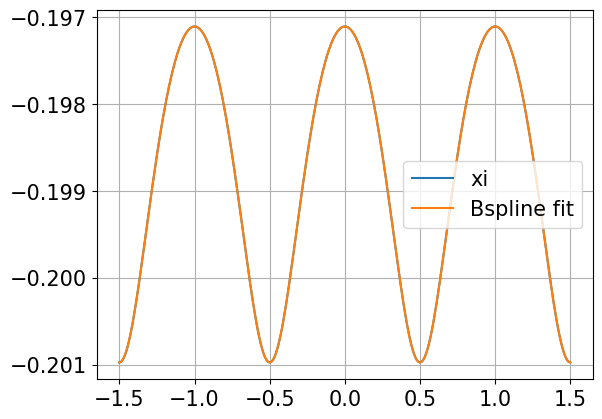

In [15]:
# Plot and fit xi(x)
x = collect(-1.5:0.01:1.5)
xi = perturbative_transmon_anharm.(Ec, EJ_small, EJ_large, x)

plot(x, xi, label="xi")

# Use a Bspine to fit xi
using BSplineKit
order = 2
spline_xi = interpolate(x, xi, BSplineOrder(order))

fit = spline_xi.(x)
# fit = 0.00194*sin.(2*pi*(x.+0.25)) .- 0.19904
plot(x, fit, label="Bspline fit")
legend()
grid()

In [16]:
io = open("x.dat", "w") do io
  for i in x
    println(io, i)
  end
end

In [17]:
ln = [1 2 4 5 10 11 13 14 28 29 31 32 37 38 40 41] # indces of initial conditions
Iden = [1.0 0.0 0.0; 0.0 1.0 0.0]⊗[1.0 0.0 0.0; 0.0 1.0 0.0] 
rho_final = []
for k in 1:1:length(ln)
    #set initial condition 
    IM = Matrix{ComplexF64}(I, 81,81)
    rhoin = reshape(IM[:,ln[k]],9,9)
#     println(k, " rhoin=", rhoin)
    
    # System setup here...
    
    # Evolve the system
#     ρs = me_state(cqs, times, ρin);
#     ρf = Iden*reshape(ρs[end],9,9)*Iden' #project on to qubits subspace
#     append!(rho_final,   [reshape(ρf,16,1)])
end
# final_process_matrix  = hcat([rho_final[l] for l=1:length(ln)]...)     # noisey process matrix
# iSWAP_infidelity= infidelity(final_process_matrix,UiSWAP,zeros(2))

In [18]:
Iden = [1.0 0.0 0.0; 0.0 1.0 0.0]⊗[1.0 0.0 0.0; 0.0 1.0 0.0] 

4×9 Matrix{Float64}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0

In [19]:
# ORIGINAL: Fidelities of CZ gates with T1, T2
CZ_infidelity = []
rho_tstop = []
# for lm in 1:1:2  #iterates over gates CZ02 CZ20  
for lm in 1:1:1 
    tff = tf[lm] 
    
    times = collect(0.0:1:tf_with_pads[lm])

    rho_final = []
#     for k in 1:1:length(ln) # iterates over initial conditions
    for k in 1:1:1 # iterates over initial conditions
        IM = Matrix{ComplexF64}(I, 81,81)
        ρin = reshape(IM[:,ln[k]],9,9)
#         print("rho_in", ρin)

        cqs = CompositeQSystem([q0, q1]) # construct the composite system
        add_hamiltonian!(cqs, q1)
        add_hamiltonian!(cqs, parametric_drive(q0, t -> phim*erfsquare_with_pads(tramp,tff,pad_length,t).*sin(2π*fm_opt_list_CZ[lm]*t)), q0)
#         add_hamiltonian!(cqs, parametric_drive(q0, driveq0), q0)
        add_hamiltonian!(cqs, g01*X([q0, q1]), [q0,q1])
#         println(hamiltonian(cqs))
#         stop


#         add_lindblad!(cqs, sqrt(γ1t)*σ0, [q0])
#         add_lindblad!(cqs, sqrt(γϕt)*σz, [q0])
#         add_lindblad!(cqs, sqrt(γ1f)*σ0, [q1])
#         add_lindblad!(cqs, sqrt(γϕf)*σz, [q1])
        ρs = me_state(cqs, times, ρin);
#         print("rho_tstop = ", ρs[end])
        rho_tstop = ρs[end]
        
        ρf = Iden*reshape(ρs[end],9,9)*Iden' # project on to the computational subspace
        append!(rho_final,   [reshape(ρf,16,1)])
    end
#     UCZ = diagm(0 => [1.0,1.0,1.0,-1.0])
#     final_process_matrix  = hcat([rho_final[l] for l=1:length(ln)]...)     # noisey process matrix
#     push!(CZ_infidelity, infidelity(final_process_matrix,UCZ,zeros(2)))
end

LoadError: UndefVarError: tf not defined

In [20]:
print("ERROR=", norm(rho_tstop - rho_tstop_test))

LoadError: UndefVarError: rho_tstop_test not defined

In [21]:
projector = [1,0]*[1, 0, 0]' + [0, 1]*[0, 1, 0]' 
projector = projector ⊗ projector
# U_proj = projector * U * projector'

4×9 Matrix{Int64}:
 1  0  0  0  0  0  0  0  0
 0  1  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  0  0
 0  0  0  0  1  0  0  0  0